# Identification of Raphael’s paintings from the forgeries
*The following data, provided by Prof. Yang WANG from HKUST,* 

*[https://drive.google.com/folderview?id=0B-yDtwSjhaSCZ2FqN3AxQ3NJNTA&usp=sharing](https://drive.google.com/folderview?id=0B-yDtwSjhaSCZ2FqN3AxQ3NJNTA&usp=sharing)*

*contains a 28 digital paintings of Raphael or forgeries. Note that there are both jpeg and tiff files, so be careful with the bit depth in digitization. The following file*

*[https://docs.google.com/document/d/1tMaaSIrYwNFZZ2cEJdx1DfFscIfERd5Dp2U7K1ekjTI/edit](https://docs.google.com/document/d/1tMaaSIrYwNFZZ2cEJdx1DfFscIfERd5Dp2U7K1ekjTI/edit)*

*contains the labels of such paintings*

## Introduction
Art forgery detection can always be a difficult and complicated thing. Thanks to rapit development of modern dating and analysis techniques, the identification of forged artwork becomes much simpler. But this kind of physical examination can still risk damaging the authentic work. Luckily, deep learning models has been shown to be highly efficent and accurate tools to complete the job. 

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from skimage import transform
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import re
import math
import cv2
import copy

plt.ion()   # interactive mode

## Load Data
After downloading the files, rename it "**data.zip**" and unzip the files into `./data` folder using the Unix/Linux gzip tool from the command line terminal:

    unzip data.zip -d data


In [14]:
class ImageFolder(Dataset):
    """A generic data loader
    """
    def __init__(self, root_dir, img_names, labels, transform=None):
        self.root_dir = root_dir
        self.img_names = img_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return len(self.img_names)
    
class ToTensor(object):   
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    """
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'label': label}
    
class Resize(object):
    """Resize the input PIL Image to the given size.
    """
    def __init__(self, size):
        assert isinstance(size, (int, tuple))
        self.size = size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        h, w = image.shape[:2]
        if isinstance(self.size, int):
            if h > w:
                new_h, new_w = self.size * h / w, self.size
            else:
                new_h, new_w = self.size, self.size * w / h
        else:
            new_h, new_w = self.size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w), mode='reflect')
        return {'image': img, 'label': label}
    
class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    """
    def __init__(self, size):
        assert isinstance(size, (int, tuple))
        if isinstance(size, int):
            self.size = (size, size)
        else:
            assert len(size) == 2
            self.size = size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                left: left + new_w]
        return {'image': image, 'label': label}
    
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        for t, m, s in zip(image, self.mean, self.std):
            t.sub_(m).div_(s)
        return {'image': image, 'label': label}
    
def leaveOne(X, idx):
    return [X[i] for i in range(len(X)) if i != idx]

def keepOne(X, idx):
    return [X[idx]]

In [23]:
# load image data from data folder
data_transforms = {
    'train': transforms.Compose([
        Resize(512),
        RandomCrop(224),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        Resize(512),
        RandomCrop(224),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
image_indices = {'train': [i for i in range(29) if i not in [0, 1, 7, 10, 20, 23, 25, 26]], 
                 'test': [1, 7, 10, 20, 23, 25, 26]}

image_names = {x: [name for name in os.listdir(data_dir) if name.lower().endswith(('tif', 'tiff', 'jpg'))]
               for x in ['train', 'test']}
image_names = {x: [name for name in image_names[x] if int(re.findall(r'(\d+).', name)[0]) in image_indices[x]]
               for x in ['train', 'test']}
image_names['train'].sort(key=lambda x: int(re.findall(r'(\d+).', x)[0]))
image_names['test'].sort(key=lambda x: int(re.findall(r'(\d+).', x)[0]))

image_labels = {'train': [1] * 7 + [0] * 9 + [1] * 5, 'test': [1] * 7}
image_datasets = {x: ImageFolder(data_dir, image_names[x], 
                                 image_labels[x], transform=data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = ['Raphael', 'Not Raphael']
print(dataset_sizes)
print(class_names)

use_gpu = torch.cuda.is_available()

{'train': 21, 'test': 7}
['Raphael', 'Not Raphael']


## Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

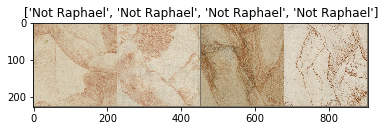

In [144]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
data = next(iter(dataloaders['train']))
inputs, classes = data['image'], data['label']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for phase in ['train', 'test']:
        # Each epoch has a training and validation phase
        if phase == 'train':
            num_folds = 21
        else:
            num_folds = 7
        cv_result = []
        for j in range(num_folds):
            print('n {}/{}'.format(j, num_folds - 1))
            print('-' * 10)
            training_datasets = ImageFolder(data_dir, leaveOne(image_names[phase], j), 
                                 leaveOne(image_labels[phase], j), transform=data_transforms[phase])
            training_loader = DataLoader(training_datasets, batch_size=4, shuffle=True)
            val_datasets = ImageFolder(data_dir, keepOne(image_names[phase], j), 
                                 keepOne(image_labels[phase], j), transform=data_transforms[phase])
            val_loader = DataLoader(val_datasets, batch_size=1, shuffle=False)
            for epoch in range(num_epochs):
                # Each epoch has a training and validation phase
                if phase == 'train':
                    scheduler.step()
                    model.train(True)  # Set model to training mode
                else:
                    model.train(False)  # Set model to evaluate mode
                    
                running_loss = 0.0
                running_corrects = 0
                for data in training_loader:
                    inputs, labels = data['image'], data['label']
                    # wrap them in Variable
                    if use_gpu:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # statistics
                    running_loss += loss.data[0] * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                epoch_loss = running_loss / (dataset_sizes[phase]-1)
                epoch_acc = running_corrects / (dataset_sizes[phase]-1)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                        phase, epoch_loss, epoch_acc))
                
                # deep copy the model
                if phase == 'train' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            model.train(False)
            predictions_eval = []
            for j in range(10):
                for data in val_loader:
                    inputs, labels = data['image'], data['label']
                    # wrap them in Variable
                    if use_gpu:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    predictions_eval.append(preds)                  
            cv_result.append(np.argmax(np.bincount(np.array(predictions_eval).reshape(-1,).astype(np.int32))))
            print('true:{} prediction:{}'.format(data['label'].numpy(), cv_result[-1]))

    print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images

In [18]:
def visualize_model(model, num_images=7):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data['image'], data['label']
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(4, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=0.1)

## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=11)

n 0/20
----------
train Loss: 0.8283 Acc: 0.3000
train Loss: 0.7305 Acc: 0.4000
train Loss: 0.7114 Acc: 0.5500
train Loss: 0.6477 Acc: 0.6500
train Loss: 0.5595 Acc: 0.7000
train Loss: 0.7956 Acc: 0.4000
train Loss: 0.5123 Acc: 0.7500
train Loss: 0.6258 Acc: 0.7500
train Loss: 0.7103 Acc: 0.6500
train Loss: 0.4407 Acc: 0.7500
train Loss: 0.5084 Acc: 0.7000
true:[1] prediction:1
n 1/20
----------
train Loss: 0.4469 Acc: 0.8000
train Loss: 0.7139 Acc: 0.6000
train Loss: 0.3747 Acc: 0.8000
train Loss: 0.4166 Acc: 0.7500
train Loss: 0.4567 Acc: 0.8000
train Loss: 0.4816 Acc: 0.7000
train Loss: 0.6512 Acc: 0.6500
train Loss: 0.3160 Acc: 0.8500
train Loss: 0.5076 Acc: 0.7000
train Loss: 0.5300 Acc: 0.7500
train Loss: 0.3280 Acc: 0.8500
true:[1] prediction:1
n 2/20
----------
train Loss: 0.3405 Acc: 0.8500
train Loss: 0.4915 Acc: 0.7500
train Loss: 0.3061 Acc: 0.9000
train Loss: 0.4805 Acc: 0.7500
train Loss: 0.4683 Acc: 0.7000
train Loss: 0.3432 Acc: 0.8500
train Loss: 0.3542 Acc: 0.8500
tra

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()